In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from common import *
import tensorflow as tf

set_random_seed(RANDOM_STATE)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
    
exp_name = 'proposed25'

2022-07-21 06:24:54.859581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 06:24:54.862104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 06:24:54.862295: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# 1. Load dataset

In [2]:
data_ = pd.read_csv(join(PATH.input, "train_data.csv"))
sample_submission = pd.read_csv(join(PATH.input, "sample_submission.csv"))
data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3859200 entries, 0 to 3859199
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 382.8+ MB


# 2. Data processing

In [3]:
IN_SEQ_LEN  = 2*144
OUT_SEQ_LEN = 2*144
STRIDE      = 1
SHUFFLE     = False
VAL_SIZE    = 0.2

In [4]:
data = generate_full_timestamp(data_)

idxs_safe = data.query(f"Day >= 200-{IN_SEQ_LEN//144}").index
data1 = data.drop(idxs_safe)
data2 = data.loc[idxs_safe]

data1 = impute_data(data1)
data1 = marking_data(data1, None).dropna()

data2 = data2.interpolate().bfill()

data = pd.concat([data1, data2])

100%|██████████| 134/134 [00:11<00:00, 11.25it/s]


* Data name: Imputing
  - Number of data: 3765334
  - Number of nan rows: 0


In [5]:
df = copy(data)
# df = df.query("TurbID == 1")

In [6]:
# from analysis_tools.eda import *

# plot_corr(data.corr())

In [7]:
# df.plot(subplots=True, figsize=(40, 20));

In [8]:
df = outlier_handler(df, ['Etmp', 'Itmp', 'Prtv'])

100%|██████████| 199/199 [00:14<00:00, 13.53it/s]


In [9]:
# df.plot(subplots=True, figsize=(40, 20));

In [10]:
def process_features(data):
    data = copy(data)
    data['Pab']  = (data['Pab1'] + data['Pab2'] + data['Pab3'])/3
    pab_rad      = np.deg2rad(data['Pab'])
    data['PabX'] = np.cos(pab_rad)
    data['PabY'] = np.sin(pab_rad)

    vals         = data['Wspd'].value_counts().index
    min_val      = vals[vals > 0][0]
    data['Wspd'] = data['Wspd'].clip(min_val, max(data['Wspd']))
    
    wd_rad = np.deg2rad(data['Wdir'])
    wv = data['Wspd']
    data['WspdX'] = wv*np.cos(wd_rad)
    data['WspdY'] = wv*np.sin(wd_rad)

    hours = data['Tmstamp'].map(lambda x: int(x.split(':')[0]) + int(x.split(':')[1]) / 60)
    data['HourX'] = np.cos(2 * np.pi * (hours / 24))
    data['HourY'] = np.sin(2 * np.pi * (hours / 24))

#     removed_cols = ['Pab1', 'Pab2', 'Pab3', 'Pab', 'Ndir', 'Wdir', 'Tmstamp', 'Day']
#     data.drop(columns=removed_cols, inplace=True)
    return data


def plot_frequency_plot(data):
    def plot(ser):
        fft = tf.signal.rfft(ser)
        f_per_dataset = np.arange(len(fft))

        n_samples_m   = len(ser)
        m_per_year    = 6*24*365.2524  # 6(10min -> hour) x 24(hour -> day) x 365.2524(day -> year)
        years_per_dataset = n_samples_m/m_per_year

        f_per_year = f_per_dataset/years_per_dataset

        plt.figure(figsize=(40, 3))
        plt.step(f_per_year, np.abs(fft))
        plt.xscale('log')
        plt.xlim([0.1, max(plt.xlim())])
        plt.xticks([1, 7, 30, 365.2524], labels=['1/Year', '1/Month', '1/Week', '1/Day'])
        plt.xlabel('Frequency (log scale)')
        plt.title(ser.name, fontsize=30, fontweight='bold')
        plt.show()
    
    d = pd.DataFrame(data)
    for col in d:
        plot(d[col])

df_fe = process_features(df)

In [11]:
df_fe

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Time,Pab,PabX,PabY,WspdX,WspdY,HourX,HourY
0,1,1,00:00,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,1,1.00,0.999848,0.017452,6.155045,-0.429323,1.000000,0.000000
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,2,1.00,0.999848,0.017452,6.155045,-0.429323,0.999048,0.043619
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,3,1.00,0.999848,0.017452,6.265462,-0.238505,0.996195,0.087156
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,4,1.00,0.999848,0.017452,6.419479,-0.081794,0.991445,0.130526
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,5,1.00,0.999848,0.017452,6.249246,0.097080,0.984808,0.173648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,200,23:10,4.86,4.68,9.04,10.40,174.39,0.01,0.01,0.01,-108.13,308.65,28796,0.01,1.000000,0.000175,4.843796,0.396530,0.976296,-0.216440
3859196,134,200,23:20,4.46,-4.00,8.79,10.33,179.76,0.01,0.01,0.01,-108.10,221.60,28797,0.01,1.000000,0.000175,4.449136,-0.311114,0.984808,-0.173648
3859197,134,200,23:30,4.23,-0.08,8.74,10.22,172.35,0.01,0.01,0.01,-108.07,220.60,28798,0.01,1.000000,0.000175,4.229996,-0.005906,0.991445,-0.130526
3859198,134,200,23:40,4.36,-6.12,8.64,10.10,172.35,0.01,0.01,0.01,-108.04,222.15,28799,0.01,1.000000,0.000175,4.335151,-0.464825,0.996195,-0.087156


In [12]:
# df.plot(subplots=True, figsize=(40, 20))
# df[:144*3].plot(subplots=True, figsize=(40, 20));

In [13]:
# plot_frequency_plot(df)

In [14]:
# %%time

# plot_corr(df.corr())
# sns.pairplot(df.iloc[:1440], kind='reg', plot_kws={'scatter_kws': {'alpha': 0.1}});

# 3. Modeling

In [15]:
cols = ['TurbID', 'Patv', 'Wspd', 'Etmp', 'Itmp', 'PabX', 'PabY', 'WspdX', 'WspdY', 'HourX', 'HourY']
num_features = len(cols)

data_input = df_fe[cols + ['Time']]
data_input

,TurbID,Patv,Wspd,Etmp,Itmp,PabX,PabY,WspdX,WspdY,HourX,HourY,Time
0,1,494.66,6.17,30.73,41.80,0.999848,0.017452,6.155045,-0.429323,1.000000,0.000000,1
1,1,494.66,6.17,30.73,41.80,0.999848,0.017452,6.155045,-0.429323,0.999048,0.043619,2
2,1,509.76,6.27,30.60,41.63,0.999848,0.017452,6.265462,-0.238505,0.996195,0.087156,3
3,1,542.53,6.42,30.52,41.52,0.999848,0.017452,6.419479,-0.081794,0.991445,0.130526,4
4,1,509.36,6.25,30.49,41.38,0.999848,0.017452,6.249246,0.097080,0.984808,0.173648,5
...,...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,308.65,4.86,9.04,10.40,1.000000,0.000175,4.843796,0.396530,0.976296,-0.216440,28796
3859196,134,221.60,4.46,8.79,10.33,1.000000,0.000175,4.449136,-0.311114,0.984808,-0.173648,28797
3859197,134,220.60,4.23,8.74,10.22,1.000000,0.000175,4.229996,-0.005906,0.991445,-0.130526,28798
3859198,134,222.15,4.36,8.64,10.10,1.000000,0.000175,4.335151,-0.464825,0.996195,-0.087156,28799


In [16]:
%%time
train_x, train_y, val_x, val_y, test_x = make_train_val_test_data(data_input, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE, SHUFFLE, VAL_SIZE, drop_TurbID=False)

100%|██████████| 134/134 [00:55<00:00,  2.43it/s]


* Data Split
  - Train data(X, y)     : (2040, 288, 11) (2040, 288, 11)
  - Validation data(X, y): (517, 288, 11) (517, 288, 11)
  - Test data(X)         : (134, 288, 11)
CPU times: user 55.6 s, sys: 830 ms, total: 56.4 s
Wall time: 55.6 s


In [17]:
train_x[0]

,TurbID,Patv,Wspd,Etmp,Itmp,PabX,PabY,WspdX,WspdY,HourX,HourY
Time,,,,,,,,,,,
99,1,264.20,4.89,37.518,46.662,0.999826,0.018674,4.826138,0.787716,-0.422618,-0.906308
100,1,305.86,4.28,37.884,46.556,0.999848,0.017452,4.278629,0.108304,-0.382683,-0.923880
101,1,326.50,5.34,38.250,46.450,0.999851,0.017278,5.281620,-0.787459,-0.342020,-0.939693
102,1,55.45,3.75,38.090,46.280,0.999851,0.017278,3.749884,0.029452,-0.300706,-0.953717
103,1,1.78,4.03,38.460,46.975,0.999544,0.030190,3.485855,2.022305,-0.258819,-0.965926
...,...,...,...,...,...,...,...,...,...,...,...
382,1,1367.64,10.21,29.130,42.400,0.999842,0.017801,10.207943,0.204914,-0.608761,-0.793353
383,1,1377.27,10.32,29.200,42.530,0.999842,0.017801,10.285150,-0.847401,-0.573576,-0.819152
384,1,1404.11,10.54,29.380,42.760,0.999842,0.017801,10.539900,-0.045989,-0.537300,-0.843391


In [18]:
# df_std = copy(df)
# df_std.loc[:, :] = scaler.transform(df)
# df_std = df_std.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(20, 5))
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# ax.set_xticklabels(df.keys(), rotation=45);

In [19]:
df_fe[cols]

,TurbID,Patv,Wspd,Etmp,Itmp,PabX,PabY,WspdX,WspdY,HourX,HourY
0,1,494.66,6.17,30.73,41.80,0.999848,0.017452,6.155045,-0.429323,1.000000,0.000000
1,1,494.66,6.17,30.73,41.80,0.999848,0.017452,6.155045,-0.429323,0.999048,0.043619
2,1,509.76,6.27,30.60,41.63,0.999848,0.017452,6.265462,-0.238505,0.996195,0.087156
3,1,542.53,6.42,30.52,41.52,0.999848,0.017452,6.419479,-0.081794,0.991445,0.130526
4,1,509.36,6.25,30.49,41.38,0.999848,0.017452,6.249246,0.097080,0.984808,0.173648
...,...,...,...,...,...,...,...,...,...,...,...
3859195,134,308.65,4.86,9.04,10.40,1.000000,0.000175,4.843796,0.396530,0.976296,-0.216440
3859196,134,221.60,4.46,8.79,10.33,1.000000,0.000175,4.449136,-0.311114,0.984808,-0.173648
3859197,134,220.60,4.23,8.74,10.22,1.000000,0.000175,4.229996,-0.005906,0.991445,-0.130526
3859198,134,222.15,4.36,8.64,10.10,1.000000,0.000175,4.335151,-0.464825,0.996195,-0.087156


In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_fe[cols])

train_x_norm = scale(train_x, scaler)
train_y_norm = scale(train_y, scaler)
val_x_norm   = scale(val_x, scaler)
val_y_norm   = scale(val_y, scaler)
test_x_norm  = scale(test_x, scaler)

In [21]:
BATCH_SIZE = 32

train_ds = generate_dataset(train_x_norm, train_y_norm, batch_size=BATCH_SIZE, shuffle=True)
val_ds   = generate_dataset(val_x_norm, val_y_norm, batch_size=BATCH_SIZE, shuffle=True)
test_ds  = generate_dataset(test_x_norm, batch_size=1)

2022-07-21 06:26:35.462109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-21 06:26:35.462921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 06:26:35.463199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 06:26:35.463355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [22]:
from tensorflow import keras
from tensorflow.keras import layers

# class FeedBack(keras.Model):
#     def __init__(self, units, out_steps):
#         super().__init__()
#         self.out_steps = out_steps
#         self.units = units
#         self.lstm_cell = layers.LSTMCell(units)
#         self.lstm_rnn = layers.RNN(self.lstm_cell, return_state=True)
#         self.dense = layers.Dense(num_features)
#     def warmup(self, inputs):
#         x, *state = self.lstm_rnn(inputs)  # (B, S, F) -> (B, lstm_units)
#         prediction = self.dense(x)
#         return prediction, state
#     def call(self, inputs, training=None):
#         predictions = []
#         prediction, state = self.warmup(inputs)
#         predictions.append(prediction)
        
#         for n in range(1, self.out_steps):
#             x = prediction
#             x, state = self.lstm_cell(x, states=state, training=training)
#             prediction = self.dense(x)
#             predictions.append(prediction)
#         predictions = tf.stack(predictions)  # (S, B, F)
#         predictions = tf.transpose(predictions, [1, 0, 2])  # (S, B, F) -> (B, S, F)
#         return predictions
    
    
# def build_model(input_shape, output_shape):
#     S,  F  = input_shape
#     S_, F_ = output_shape
#     model = keras.Sequential(name="GRU-Model") # Model
#     model.add(keras.Input(shape=(S, F), name='Input-Layer'))
#     model.add(layers.Bidirectional(layers.GRU(units=256, activation='tanh', recurrent_activation='sigmoid', stateful=False), name='Hidden-GRU-Encoder-Layer'))
#     model.add(layers.RepeatVector(S_, name='Repeat-Vector-Layer'))
#     model.add(layers.Bidirectional(layers.GRU(units=256, activation='tanh', recurrent_activation='sigmoid', stateful=False), name='Hidden-GRU-Encoder-Layer2'))
#     model.add(layers.RepeatVector(S_, name='Repeat-Vector-Layer2'))
#     model.add(layers.Bidirectional(layers.GRU(units=256, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer'))
#     model.add(layers.TimeDistributed(layers.Dense(units=F_), name='Output-Layer'))
#     return model


def build_model(input_shape, output_shape, units, n_blocks, dropout=None):
    S,  F  = input_shape
    S_, F_ = output_shape
    
    model = keras.Sequential(name="GRU-Model") # Model
    model.add(keras.Input(shape=(S, F), name='Input-Layer'))

    for _ in range(n_blocks):
        model.add(layers.Bidirectional(layers.GRU(units, return_sequences=True, dropout=dropout)))
    
    model.add(layers.Dense(units=F_))
    return model

In [23]:
from tensorflow.keras import losses, metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from livelossplot import PlotLossesKeras

class PartialLoss(losses.Loss):
    def __init__(self, loss_fn, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn = loss_fn
    def call(self, y_true, y_pred):
        _, S, F = y_true.shape
        
        # [0]: TurbID
        # [1]: Patv
        y_true = y_true[:, :, 2:]
        y_pred = y_pred[:, :, 2:]
        res = y_true - y_pred

        if self.loss_fn == 'rmse':
            return tf.sqrt(tf.reduce_mean(tf.square(res)))
        elif self.loss_fn == 'mse':
            return tf.reduce_mean(tf.square(res))
        elif self.loss_fn == 'mae':
            return tf.reduce_mean(tf.abs(res))
        else:
            raise NotImplementedError

            
def compile_and_fit(model, train_ds, val_ds, epochs, patience_es=10, patience_lr=3):
    model.compile('nadam', loss=PartialLoss(loss_fn='mae'), metrics=[metrics.RootMeanSquaredError(), 'mae'])
    
    ckpt_dir = join(PATH.ckpt, exp_name)
    os.makedirs(ckpt_dir, exist_ok=True)
    
    return model.fit(train_ds, validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[
                        PlotLossesKeras(),
                        EarlyStopping(patience=patience_es, restore_best_weights=True),
                        ReduceLROnPlateau(patience=patience_lr),
                        ModelCheckpoint(join(ckpt_dir, '[{epoch:03d} epoch].h5'), save_best_only=False, save_weights_only=True),
                    ])

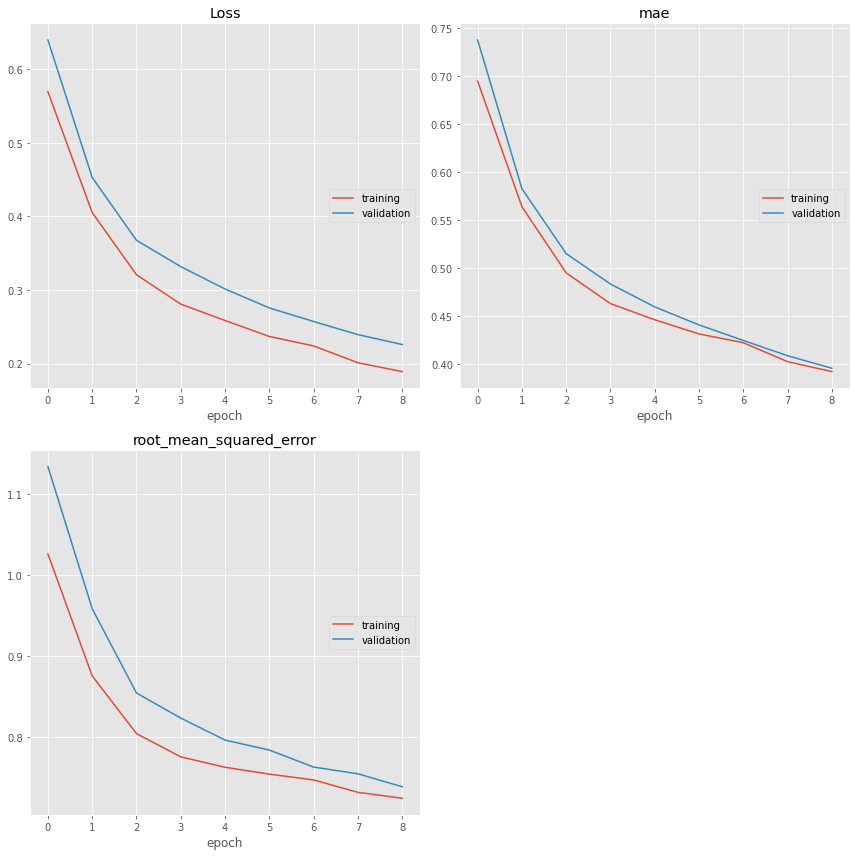

Loss
	training         	 (min:    0.189, max:    0.569, cur:    0.189)
	validation       	 (min:    0.226, max:    0.640, cur:    0.226)
mae
	training         	 (min:    0.392, max:    0.695, cur:    0.392)
	validation       	 (min:    0.396, max:    0.738, cur:    0.396)
root_mean_squared_error
	training         	 (min:    0.724, max:    1.026, cur:    0.724)
	validation       	 (min:    0.738, max:    1.134, cur:    0.738)
64/64 [==============================] - 16s 252ms/step - loss: 0.1892 - root_mean_squared_error: 0.7239 - mae: 0.3923 - val_loss: 0.2260 - val_root_mean_squared_error: 0.7381 - val_mae: 0.3959 - lr: 0.0010
Epoch 10/1000
22/64 [=========>....................] - ETA: 9s - loss: 0.1851 - root_mean_squared_error: 0.7479 - mae: 0.4071

In [ ]:
model = build_model(input_shape=train_x[0].shape, output_shape=train_y[0].shape, units=256, n_blocks=4, dropout=0.3)
model.summary()
compile_and_fit(model, train_ds, val_ds, epochs=1000, patience_es=30, patience_lr=5)

In [ ]:
def plot_result(model, scaler, df_fe, Pmax_params, n_cols=5):
    n_rows = num_features

    for ds in (train_ds, val_ds):
        for X, y in ds.take(1):
            X = X[:n_cols]
            y = y[:n_cols]

        inputs = [pd.DataFrame(inverse_scale(d, scaler), columns=cols) for d in X]
        trues  = [pd.DataFrame(inverse_scale(d, scaler), columns=cols) for d in y]
        preds  = [pd.DataFrame(inverse_scale(d, scaler), columns=cols) for d in model.predict(X, verbose=0)]
        
        for input, pred in zip(inputs, preds):
            pred['TurbID'] = input['TurbID'].values
            pred['Patv']   = compute_Pmax(pred, **Pmax_params)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(40, 20))
        for ax_col, col in zip(axes, cols):
            for idx_row, (ax, true, pred) in enumerate(zip(ax_col, trues, preds)):
                ax.plot(true[col], label='true')
                ax.plot(pred[col], label=f'pred ({np.mean(abs(pred[col]-true[col])):.3f})')
                ax.fill_between(range(len(true[col])), true[col], pred[col], alpha=0.1, color='b')
                ax.set_xticklabels([])
                ax.legend()
                if idx_row == 0:
                    ax.set_ylabel(col)
        fig.tight_layout()
        plt.show()

In [ ]:
Pmax_params = {
    'constants'       : compute_Pmax_constants(df_fe),
    'clipping_min_val': df_fe['Patv'].min(),
    'clipping_max_val': df_fe['Patv'].max()    
}

In [ ]:
plot_result(model, scaler, df_fe, Pmax_params, n_cols=10)

In [ ]:
# ckpt_dir = join(PATH.ckpt, 'Wspd_forecasting-real')
# model.load_weights(join(ckpt_dir, '[145 epoch].h5'))

In [ ]:
def compute_test_Patv(model, test_x, test_ds, cols, Pmax_params):
    X      = pd.concat(test_x)
    y_pred = inverse_scale(model.predict(test_ds), scaler).reshape(-1, X.shape[-1])
    y_pred = pd.DataFrame(y_pred, columns=cols)

    y_pred['TurbID'] = X['TurbID'].values
    y_pred['Patv']   = compute_Pmax(y_pred, **Pmax_params)
    return y_pred['Patv']

sample_submission['Patv'] = compute_test_Patv(model, test_x, test_ds, cols, Pmax_params)
sample_submission.to_csv(join(PATH.output, f"{exp_name}.csv"), index=False)

In [ ]:
sample_submission['Patv']